In [1]:
import pandas as pd

# 加载数据
df = pd.read_csv('merged.csv', parse_dates=['decision_date', 'sentiment_date'])

# 查看前几行数据
print(df.head())

  decision_date  rate_change   decision sentiment_date  sentiment  \
0    1996-11-13         0.00  No Change     1996-10-30   0.028881   
1    1996-12-17         0.00  No Change     1996-12-04  -0.588398   
2    1997-02-05         0.00  No Change     1997-01-22   0.123663   
3    1997-03-25         0.25   Increase     1997-03-12  -0.728463   
4    1997-05-20         0.00  No Change     1997-05-07  -0.035630   

                                      sentiment_dict  days_difference  
0  {'positive': 0.1624157875776291, 'negative': 0...               14  
1  {'positive': 0.07799529284238815, 'negative': ...               13  
2  {'positive': 0.17666494846343994, 'negative': ...               14  
3  {'positive': 0.02856595441699028, 'negative': ...               13  
4  {'positive': 0.16252721846103668, 'negative': ...               13  


/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from sklearn.preprocessing import LabelEncoder

# 创建 LabelEncoder 实例
le = LabelEncoder()

# 对 'decision' 列进行编码
df['decision_encoded'] = le.fit_transform(df['decision'])

# 显示编码后的映射关系
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Label Mapping:', label_mapping)

Label Mapping: {'Decrease': 0, 'Increase': 1, 'No Change': 2}


In [3]:
# 创建滞后特征
# 创建多个滞后期的情感得分
for lag in range(1, 7):  # 可以根据需要调整滞后期数
    df[f'sentiment_lag_{lag}'] = df['sentiment'].shift(lag)

# 删除由于滞后导致的缺失值
df.dropna(inplace=True)


In [4]:
# 计算滚动统计特征
# 计算3期滚动均值和滚动标准差
df['sentiment_roll_mean_3'] = df['sentiment'].rolling(window=3).mean()
df['sentiment_roll_std_3'] = df['sentiment'].rolling(window=3).std()

# 计算6期滚动均值和滚动标准差
df['sentiment_roll_mean_6'] = df['sentiment'].rolling(window=6).mean()
df['sentiment_roll_std_6'] = df['sentiment'].rolling(window=6).std()

# 删除由于滚动计算导致的缺失值
df.dropna(inplace=True)


In [5]:
# 添加时间特征
# 提取日期中的时间特征
df['month'] = df['sentiment_date'].dt.month
df['quarter'] = df['sentiment_date'].dt.quarter
df['year'] = df['sentiment_date'].dt.year


In [6]:
# 计算差分和变化率
# 计算情感得分的一阶差分
df['sentiment_diff'] = df['sentiment'].diff()

# 计算情感得分的百分比变化率
df['sentiment_pct_change'] = df['sentiment'].pct_change()

# 删除由于差分计算导致的缺失值
df.dropna(inplace=True)


In [7]:
# 处理季节性和周期性
from statsmodels.tsa.seasonal import seasonal_decompose

# 假设你的情感得分按日期排序，并且日期为索引
result = seasonal_decompose(df['sentiment'], model='additive', period=12)
df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['residual'] = result.resid

# 删除缺失值
df.dropna(inplace=True)


In [10]:
features = [
    'sentiment',
    'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_lag_3',
    'sentiment_roll_mean_3', 'sentiment_roll_std_3',
    'sentiment_diff', 'sentiment_pct_change',
    'month', 'quarter', 'year',
    'trend', 'seasonal', 'residual'
]
X = df[features]
y = df['decision_encoded']


In [11]:
# 划分训练集和测试集
# 按时间顺序划分数据
split_ratio = 0.8  # 80% 用于训练，20% 用于测试
split_index = int(len(df) * split_ratio)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# 检查数据集大小
print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)


Training set size: (146, 14)
Test set size: (37, 14)


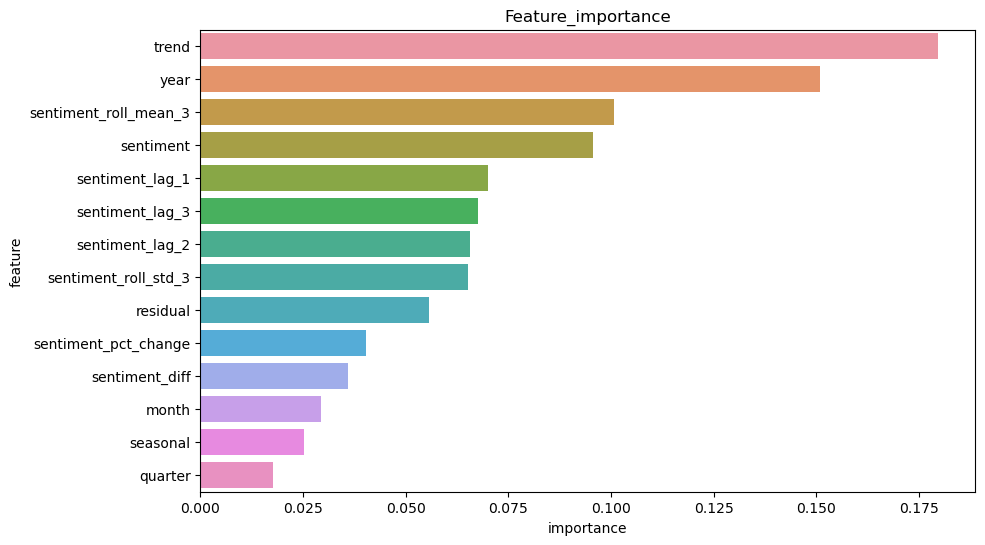

In [13]:
# 基于模型的特征重要性
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 使用随机森林模型进行特征重要性分析
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 获取特征重要性
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature_importance')
plt.show()



In [15]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# 使用逻辑回归模型进行 RFE
lr = LogisticRegression(max_iter=1000, random_state=42)
selector = RFE(estimator=lr, n_features_to_select=10)  # 选择保留的特征数量
selector = selector.fit(X_train, y_train)

# 获取选择的特征
selected_features = X_train.columns[selector.support_]
print("选择的特征：", selected_features)


选择的特征： Index(['sentiment', 'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_lag_3',
       'sentiment_roll_mean_3', 'sentiment_roll_std_3', 'sentiment_diff',
       'quarter', 'trend', 'residual'],
      dtype='object')


/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# Lasso 回归进行特征选择
from sklearn.linear_model import LogisticRegressionCV

# 使用带 L1 正则化的逻辑回归进行特征选择
lasso = LogisticRegressionCV(cv=5, penalty='l1', solver='saga', random_state=42, max_iter=1000)
lasso.fit(X_train, y_train)

# 获取系数不为零的特征
coef = pd.Series(lasso.coef_[0], index=X_train.columns)
selected_features = coef[coef != 0].index
print("选择的特征：", selected_features)


/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


选择的特征： Index(['year'], dtype='object')


特征选择后的分析

In [17]:
selected_features = [
    'sentiment',
    'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_lag_3',
    'sentiment_roll_mean_3', 'sentiment_roll_std_3',
    'sentiment_diff', 
    'year',
    'trend', 
]
X1 = df[selected_features]
y1 = df['decision_encoded']

In [19]:
# 划分训练集和测试集
# 按时间顺序划分数据
split_ratio = 0.8  # 80% 用于训练，20% 用于测试
split_index = int(len(df) * split_ratio)

X_train1 = X1.iloc[:split_index]
X_test1 = X1.iloc[split_index:]
y_train1 = y1.iloc[:split_index]
y_test1 = y1.iloc[split_index:]

# 检查数据集大小
print('Training set size:', X_train1.shape)
print('Test set size:', X_test1.shape)


Training set size: (146, 9)
Test set size: (37, 9)


In [20]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report

# 定义参数网格
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# 使用时间序列拆分
tscv = TimeSeriesSplit(n_splits=5)

# 创建 XGBoost 分类模型
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 使用随机搜索进行调优
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid_xgb,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 进行超参数调优
random_search_xgb.fit(X_train1, y_train1)

# 输出最佳参数
print("XGBoost 最佳参数：", random_search_xgb.best_params_)

# 使用最佳模型进行预测
best_xgb_clf = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_clf.predict(X_test1)

# 评估模型
print("=== XGBoost 调优后分类模型评估 ===")
print(classification_report(y_test1, y_pred_best_xgb, target_names=le.classes_))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas re

XGBoost 最佳参数： {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}
=== XGBoost 调优后分类模型评估 ===
              precision    recall  f1-score   support

    Decrease       0.00      0.00      0.00         5
    Increase       0.20      0.18      0.19        11
   No Change       0.52      0.67      0.58        21

    accuracy                           0.43        37
   macro avg       0.24      0.28      0.26        37
weighted avg       0.35      0.43      0.39        37



/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
